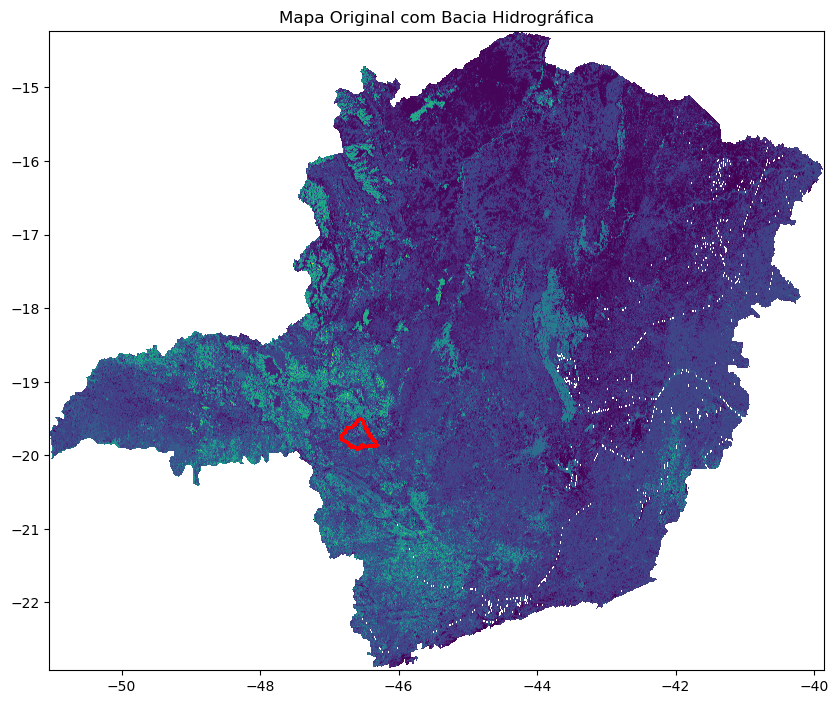

Reprojetando raster para WGS84...


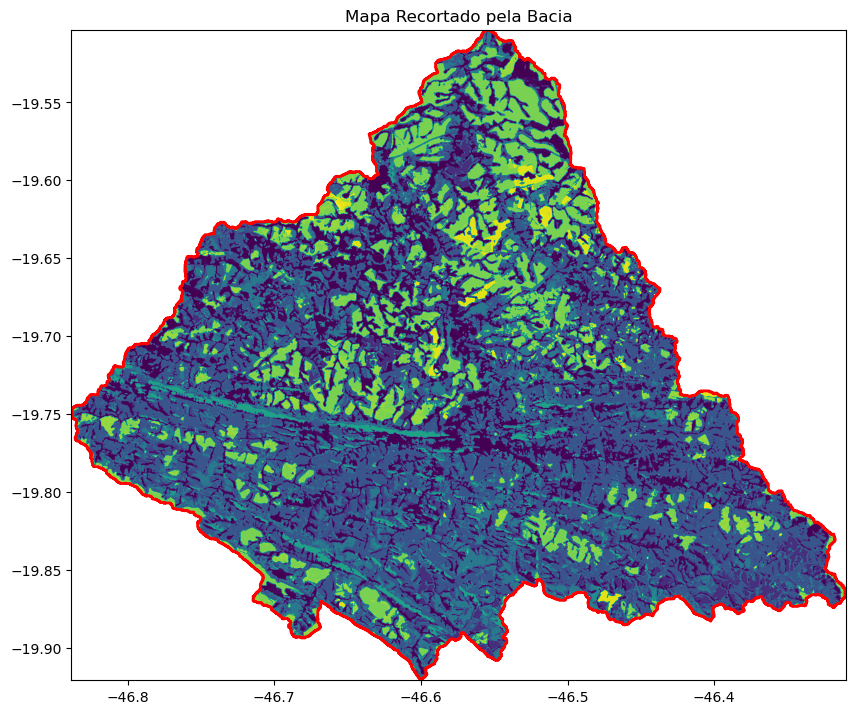


=== RESULTADOS FINAIS ===
Área total da bacia: 1302.689641 km²
Área do pixel: 0.000844 km²

Tabela de resultados salva em: resultados_uso_solo_bacia.xlsx
Visualizações salvas como: mapa_original.png e mapa_recortado.png

Tabela de Uso do Solo:
   Código                               Classe   Área (km²)  \
0      15                        15 - Pastagem   372.241769   
1      21                 21 - Mosaico de usos   240.761247   
2       3               3 - Formação Florestal   232.247598   
3      39                            39 - Soja   143.710876   
4       4                4 - Formação Savânica    95.127036   
5      41     41 - Outras Lavouras Temporárias    70.370950   
6      12              12 - Formação Campestre    55.072037   
7      29             29 - Afloramento Rochoso    30.629052   
8       9                     9 - Silvicultura    27.885409   
9      46                            46 - Café    16.654278   
10     11  11 - Campo Alagado e Área Pantanosa    13.873502   

In [3]:
def analisar_uso_solo_bacia(raster_path, shapefile_path, output_table_path, qml_path):
    """
    Analisa o uso do solo em uma bacia hidrográfica a partir de um raster do MapBiomas,
    calculando áreas em quilômetros quadrados (km²) e gerando visualizações.
    """
    
    class_mapping = extrair_classes_qml(qml_path)
    if not class_mapping:
        print("Não foi possível extrair as classes do arquivo QML. Verifique o caminho.")
        return
    
    bacia = gpd.read_file(shapefile_path)
    if bacia.crs != 'EPSG:4326':
        bacia = bacia.to_crs('EPSG:4326')
    
    geod = Geod(ellps="WGS84")
    temp_raster = None
    
    try:
        with rasterio.open(raster_path) as src:
            # Plotar raster original com bacia
            plotar_mapa(src, bacia, "Mapa Original com Bacia Hidrográfica", "mapa_original.png")
            
            if src.crs != 'EPSG:4326':
                print("Reprojetando raster para WGS84...")
                temp_raster = reprojetar_raster_para_wgs84(raster_path)
                raster_to_use = temp_raster
            else:
                raster_to_use = raster_path
        
        with rasterio.open(raster_to_use) as src:
            # Recortar raster pela bacia
            out_image, out_transform = mask(src, bacia.geometry, crop=True, nodata=0)
            out_meta = src.meta.copy()
            
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "nodata": 0
            })
            
            # Salvar raster recortado temporariamente para visualização
            temp_recorte = tempfile.NamedTemporaryFile(suffix='.tif', delete=False).name
            with rasterio.open(temp_recorte, 'w', **out_meta) as dest:
                dest.write(out_image)
            
            # Plotar raster recortado
            with rasterio.open(temp_recorte) as src_recorte:
                plotar_mapa(src_recorte, bacia, "Mapa Recortado pela Bacia", "mapa_recortado.png")
            
            # Calcular áreas em km²
            x0, y0 = rasterio.transform.xy(out_transform, 0, 0)
            x1, y1 = rasterio.transform.xy(out_transform, 1, 1)
            pixel_poly = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1), (x0, y0)])
            pixel_area_km2 = calcular_area_geodesica_km2(pixel_poly, geod)
            
            classes = out_image[0]
            classes = classes[classes != 0]
            unique_classes, counts = np.unique(classes, return_counts=True)
            
            areas_km2 = np.round(counts * pixel_area_km2, 6)  # 6 casas decimais para km²
            
            # Criar DataFrame com os resultados
            df = pd.DataFrame({
                "Código": unique_classes,
                "Classe": [class_mapping.get(c, f"Desconhecido ({c})") for c in unique_classes],
                "Área (km²)": areas_km2,
                "Contagem de pixels": counts
            })
            
            df = df.sort_values("Área (km²)", ascending=False)
            
            # Calcular área total
            area_total = df["Área (km²)"].sum()
            
            # Adicionar linha com o total
            total_row = pd.DataFrame({
                "Código": ["-"],
                "Classe": ["TOTAL"],
                "Área (km²)": [area_total],
                "Contagem de pixels": [df["Contagem de pixels"].sum()]
            })
            
            df = pd.concat([df, total_row], ignore_index=True)
            
            # Salvar tabela em Excel
            # Verifica se a extensão é .xlsx, se não, substitui
            if not output_table_path.lower().endswith('.xlsx'):
                output_table_path = os.path.splitext(output_table_path)[0] + '.xlsx'
            
            df.to_excel(output_table_path, index=False, float_format="%.6f")
            
            print("\n=== RESULTADOS FINAIS ===")
            print(f"Área total da bacia: {area_total:.6f} km²")
            print(f"Área do pixel: {pixel_area_km2:.6f} km²")
            print(f"\nTabela de resultados salva em: {output_table_path}")
            print(f"Visualizações salvas como: mapa_original.png e mapa_recortado.png")
            
            return df
    
    finally:
        if temp_raster and os.path.exists(temp_raster):
            os.remove(temp_raster)
        if 'temp_recorte' in locals() and os.path.exists(temp_recorte):
            os.remove(temp_recorte)

# Exemplo de uso modificado para Excel
if __name__ == "__main__":
    raster_mapbiomas = r"C:\Projetos\Metodos Estatisticos 1\Metodos Estatisticos\ide_1402_mg_uso_terra_mapbiomas_col9_2023.tif"
    shapefile_bacia = r"C:\Users\ecaputo\DC\ACCDocs\DF\DF24-C110\Project Files\ELAB\RHI\2_SIG\SHP__\Bacia_60250000.shp"
    output_table = "resultados_uso_solo_bacia.xlsx"  # Alterado para .xlsx
    qml_file = r"C:\Projetos\Metodos Estatisticos 1\Metodos Estatisticos\ide_1402_mg_uso_terra_mapbiomas_col9_estilo.qml"
    
    resultados = analisar_uso_solo_bacia(
        raster_mapbiomas, 
        shapefile_bacia, 
        output_table, 
        qml_path=qml_file
    )
    print("\nTabela de Uso do Solo:")
    print(resultados)

In [4]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [ ]:
def CalculoMaximas(df, maximo_falhas, inicio_ano_hidrologico, fim_ano_hidrologico, meses_cheia= None):
    # Calcula o menor M7 para cada ano
    df_maximas_anual = Q710.calcular_m7_min_anual(df, maximo_falhas) 

    # Criando instâncias das distribuições GumbelMin e Weibull
    gumbel_max_dist = Gumbel()
    weibull_max_dist = Weibull_Max()
    GEV_dist = GEV()
    Gama_dist = Gama()
    #Frechet_dist = Frechet()
    #LogNormal_dist = LogNormal()

    # Criando instância do DistribuitionSelector
    selector = DistribuitionSelector()

    # Adicionando as distribuições ao selector
    selector.appendDistribuition(gumbel_max_dist)
    selector.appendDistribuition(weibull_max_dist)
    selector.appendDistribuition(GEV_dist)
    selector.appendDistribuition(Gama_dist)
    #selector.appendDistribuition(Frechet_dist)
    #selector.appendDistribuition(LogNormal_dist)

    # Ajustando as distribuições aos dados
    selector.fit(df_maximas_anual['Valor'], method='mvs')

    # Plotando os gráficos das distribuições ajustadas
    selector.describePlot()

    # Exibindo os parâmetros ajustados
    params = selector.getParams()
    gumbel_max_dist_params = params[0]
    weibull_max_distparams = params[1]
    GEV_dist_params = params[2]
    Gama_dist_params = params[3]
    #Frechet_dist_params = params[4]
    #LogNormal_dist_params = params[5]

    # Exibindo os resultados dos testes de ajuste
    fit_test_results = selector.fitTest()
    gumbel_max_dist_fit_test = fit_test_results[0]
    weibull_max_dist_fit_test = fit_test_results[1]
    GEV_dist_fit_test = fit_test_results[2]
    Gama_dist_fit_test = fit_test_results[3]
    #Frechet_dist_fit_test = fit_test_results[4]
    #LogNormal_dist_fit_test = fit_test_results[5]

    # Calculando o valor para cada tempo de retorno em anos
    tempo_retorno = [2, 5, 10, 25, 50, 100, 200, 500, 1000, 10000]
    # Criar listas vazias para armazenar os resultados
    PPF_gumbel_max__list = []
    PPF_weibull_max_list = []
    PPF_GEV_list = []
    PPF_Gama_list = []

    for i in tempo_retorno:
        probabilidade = 1/i
        
        # Calcular os valores
        PPF_gumbel_max = gumbel_max_dist.PPF(probabilidade, *gumbel_max_dist_params)
        PPF_weibull_max = weibull_max_dist.PPF(probabilidade, *weibull_max_distparams)
        PPF_GEV = GEV_dist.PPF(probabilidade, *GEV_dist_params)
        PPF_Gama = Gama_dist.PPF(probabilidade, *Gama_dist_params)
        
        # Adicionar às listas
        PPF_gumbel_max__list.append(PPF_gumbel_max)
        PPF_weibull_max_list.append(PPF_weibull_max)
        PPF_GEV_list.append(PPF_GEV)
        PPF_Gama_list.append(PPF_Gama)



    return gumbel_max_dist_params, weibull_max_distparams, GEV_dist_params, Gama_dist_params, gumbel_max_dist_fit_test, weibull_max_dist_fit_test, GEV_dist_fit_test, Gama_dist_fit_test, PPF_gumbel_max__list, PPF_weibull_max_list, PPF_GEV_list, PPF_Gama_list